# Designing models for CRC cell lines

In [12]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import color_pal as pal
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_sampling_api
import seaborn as sns
import theano
from pymc3_models import crc_models

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 914
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [2]:
data = dphelp.read_achilles_data(
    Path("..", "modeling_data", "depmap_CRC_data_subsample.csv"), low_memory=False
)
data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated
0,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
1,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
2,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
3,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
4,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0


## Model Experimentation

In [3]:
total_size = len(data.lfc.values)
sgrna_idx, n_sgrnas = dphelp.get_indices_and_count(data, "sgrna")
sgrna_to_gene_map = (
    data[["sgrna", "hugo_symbol"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values("sgrna")
    .reset_index(drop=True)
)
sgrna_to_gene_idx, n_genes = dphelp.get_indices_and_count(
    sgrna_to_gene_map, "hugo_symbol"
)

In [4]:
sgrna_idx_shared = theano.shared(sgrna_idx)
sgrna_to_gene_idx_shared = theano.shared(sgrna_to_gene_idx)
lfc_shared = theano.shared(data.lfc.values)

In [5]:
with pm.Model() as model2:

    μ_g = pm.Normal("μ_g", 0, 5)
    σ_g = pm.HalfNormal("σ_g", 2)
    σ_σ_α = pm.HalfNormal("σ_σ_α", 2)

    μ_α = pm.Normal("μ_α", μ_g, σ_g, shape=n_genes)
    σ_α = pm.HalfNormal("σ_α", σ_σ_α, shape=n_genes)

    α_s = pm.Normal(
        "α_s",
        μ_α[sgrna_to_gene_idx_shared],
        σ_α[sgrna_to_gene_idx_shared],
        shape=n_sgrnas,
    )

    μ = α_s[sgrna_idx_shared]
    σ = pm.HalfNormal("σ", 5)

    lfc = pm.Normal("lfc", μ, σ, observed=lfc_shared, total_size=total_size)

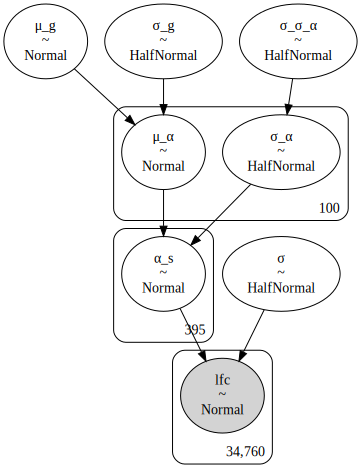

In [6]:
pm.model_to_graphviz(model2)

In [7]:
batch_size = 1000

sgnra_idx_batch = pm.Minibatch(sgrna_idx, batch_size=batch_size)
lfc_data_batch = pm.Minibatch(data.lfc.values, batch_size=batch_size)

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [25]:
m1_meanfield = pymc3_sampling_api.pymc3_advi_approximation_procedure(
    model=model2,
    method="advi",
    callbacks=[
        pm.callbacks.CheckParametersConvergence(tolerance=0.01, diff="absolute")
    ],
    fit_kwargs={
        "more_replacements": {
            sgrna_idx_shared: sgnra_idx_batch,
            lfc_shared: lfc_data_batch,
        }
    },
)

Sampling from prior distributions.
Running ADVI approximation.


Convergence achieved at 25700
Interrupted at 25,699 [25%]: Average Loss = 965.71


Sampling from posterior.
Posterior predicitons.


In [114]:
m1_fullrank = pymc3_sampling_api.pymc3_advi_approximation_procedure(
    model=model2,
    method="advi",
    n_iterations=22000,
    callbacks=[
        pm.callbacks.CheckParametersConvergence(tolerance=0.01, diff="absolute")
    ],
    fit_kwargs={
        "more_replacements": {
            sgrna_idx_shared: sgnra_idx_batch,
            lfc_shared: lfc_data_batch,
        }
    },
)

Sampling from prior distributions.
Running ADVI approximation.


Finished [100%]: Average Loss = 678.47


Sampling from posterior.
Posterior predicitons.


### Biref inspection

In [115]:
def plot_approximation_history(hist: np.ndarray) -> gg.ggplot:
    d = pd.DataFrame({"loss": hist}).reset_index(drop=False)
    return (
        gg.ggplot(d, gg.aes(x="index", y="loss"))
        + gg.geom_line(size=0.7, alpha=0.8, color=pal.sns_blue)
        + gg.scale_x_continuous(expand=(0.02, 0, 0.02, 0))
        + gg.labs(x="step", y="loss")
    )

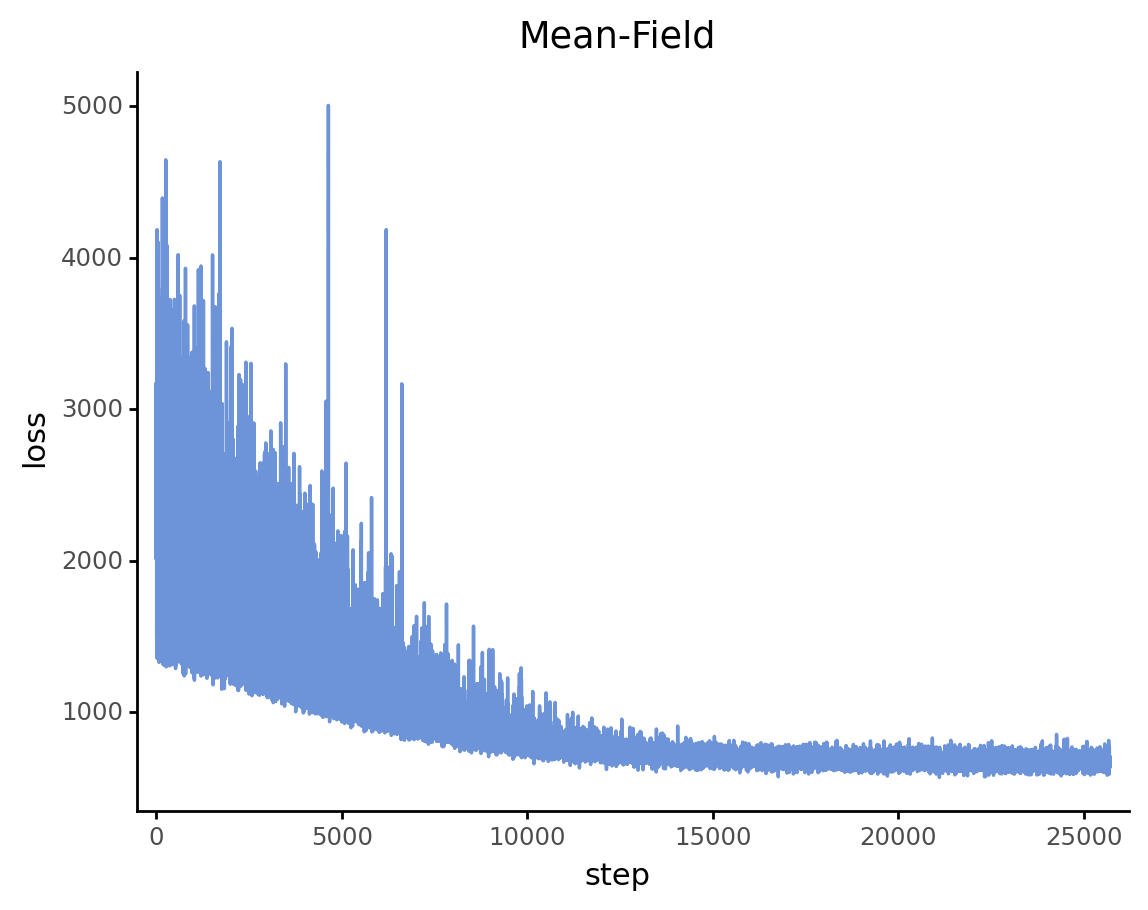

<ggplot: (8776798429106)>

In [116]:
plot_approximation_history(m1_meanfield["approximation"].hist) + gg.labs(
    title="Mean-Field"
)

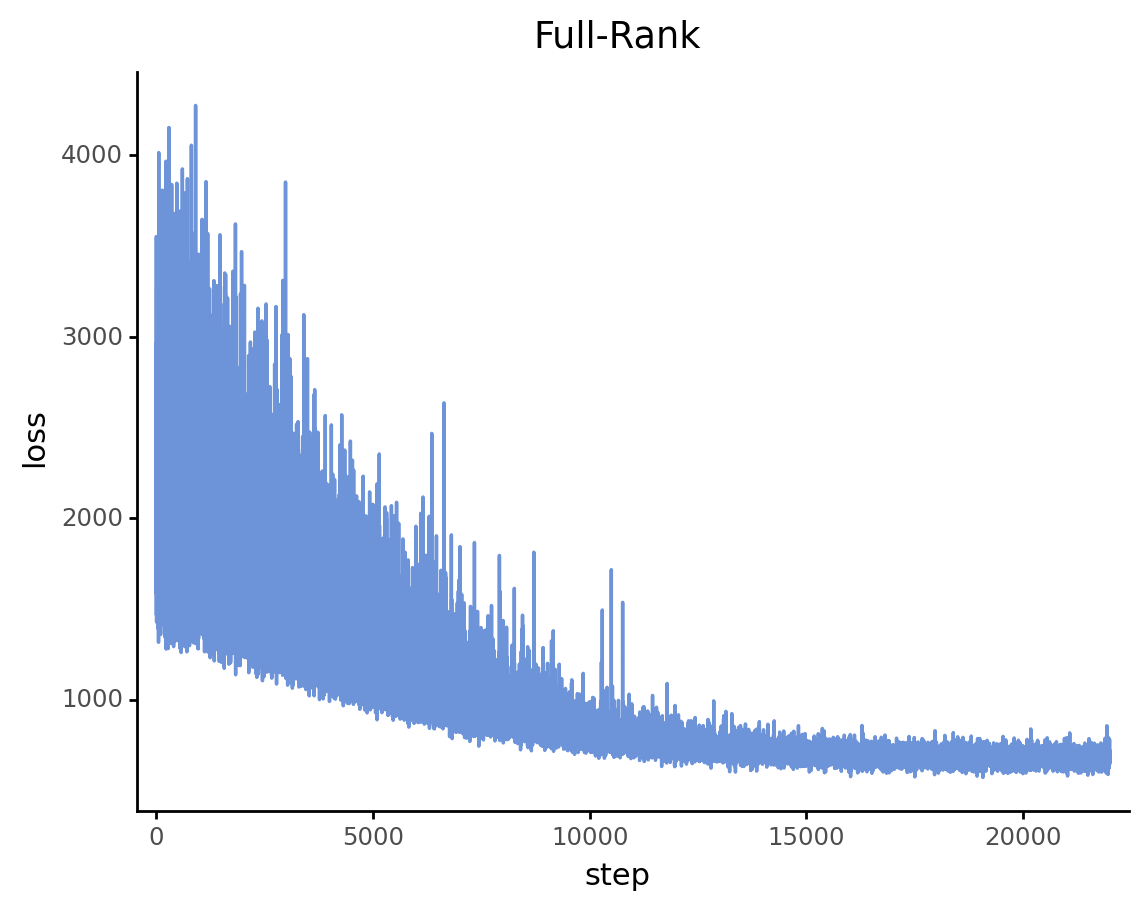

<ggplot: (8776863064221)>

In [117]:
plot_approximation_history(m1_fullrank["approximation"].hist) + gg.labs(
    title="Full-Rank"
)

In [129]:
gene_posteriors = pd.concat(
    [
        az.summary(
            pymc3_sampling_api.samples_to_arviz(model2, m1_fullrank),
            var_names="μ_α",
            hdi_prob=0.89,
        ).assign(advi="fullrank"),
        az.summary(
            pymc3_sampling_api.samples_to_arviz(model2, m1_meanfield),
            var_names="μ_α",
            hdi_prob=0.89,
        ).assign(advi="mean-field"),
    ]
)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


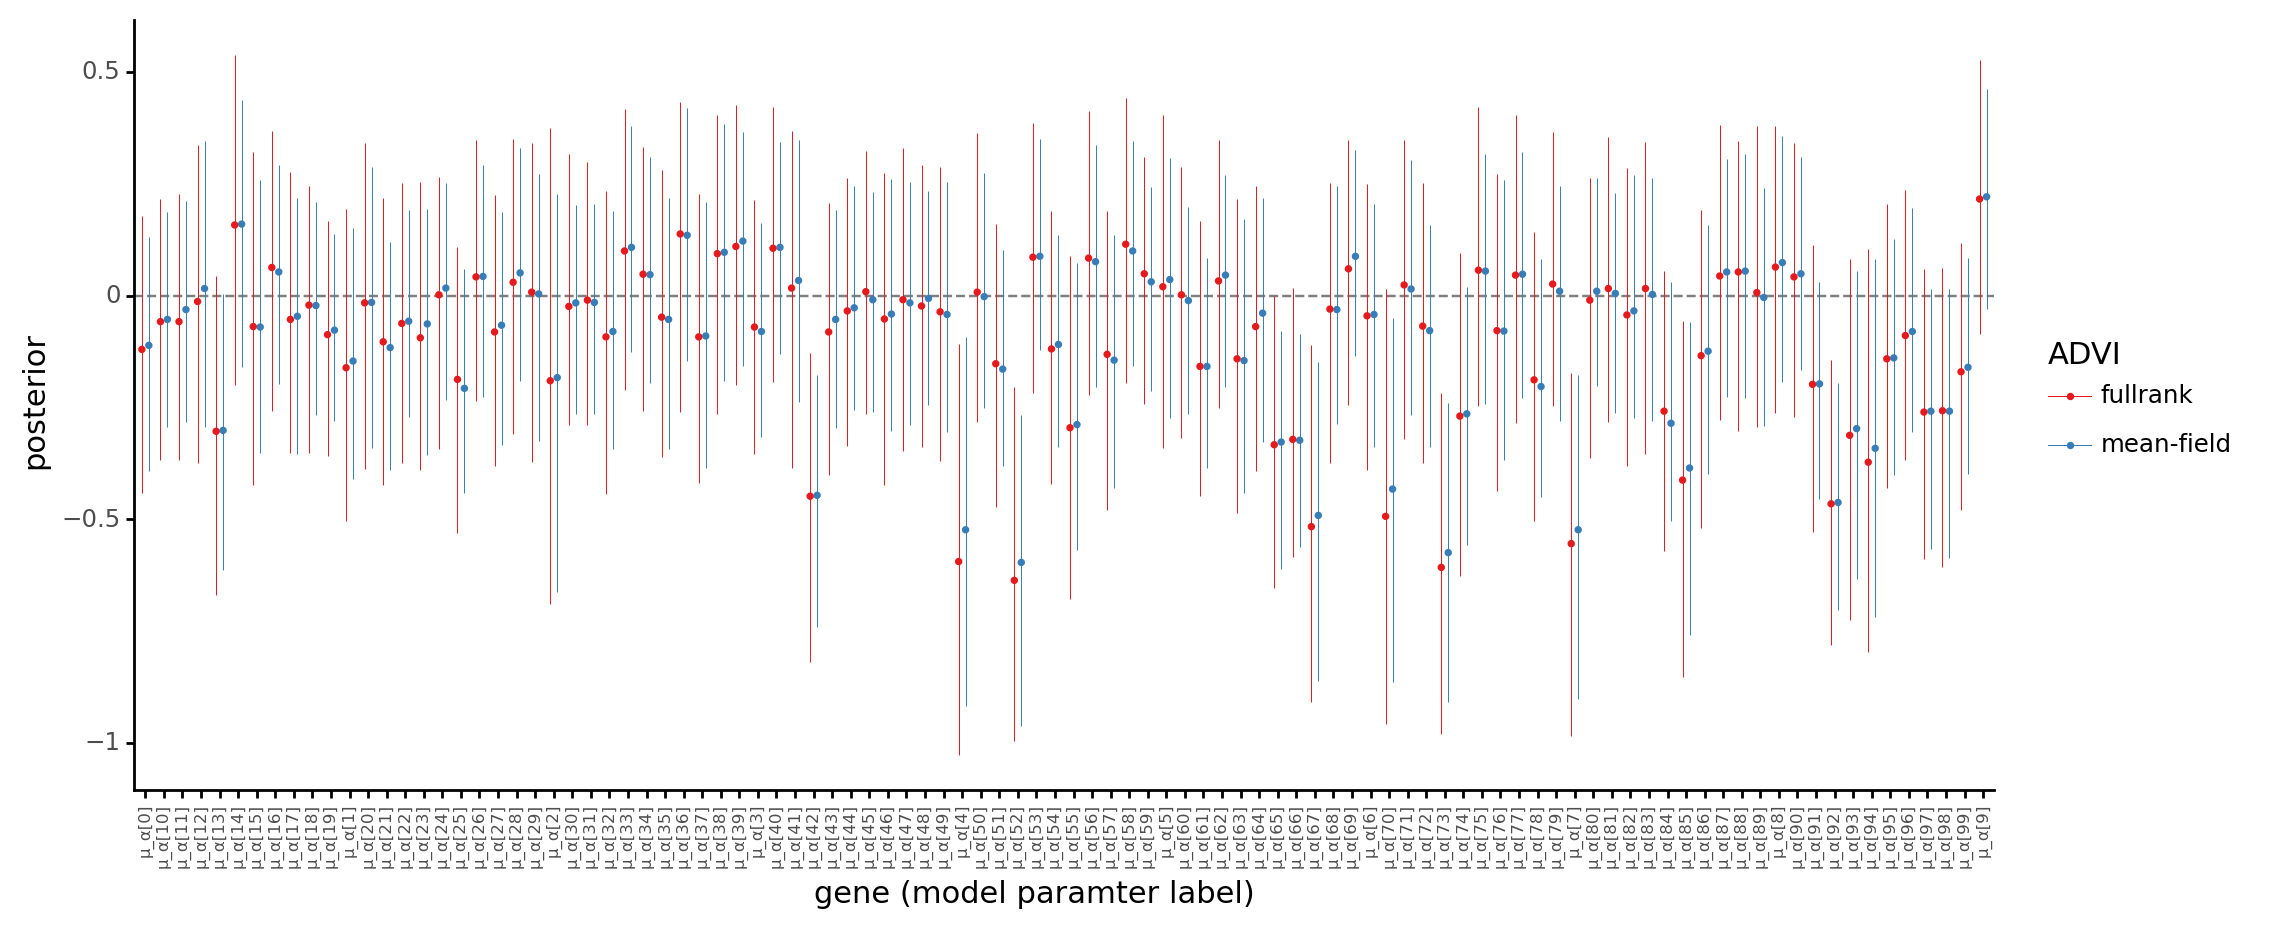

<ggplot: (8776863898618)>

In [133]:
pos = gg.position_dodge(width=0.75)
(
    gg.ggplot(gene_posteriors.reset_index(drop=False), gg.aes(x="index"))
    + gg.geom_hline(yintercept=0, linetype="--", alpha=0.5)
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="advi"), position=pos, size=0.2
    )
    + gg.geom_point(gg.aes(y="mean", color="advi"), position=pos, size=0.5)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=6), figure_size=(12, 5))
    + gg.labs(x="gene (model paramter label)", y="posterior", color="ADVI")
)

---

In [7]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.52 minutes


In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-02-16

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: crc

arviz     : 0.11.1
pandas    : 1.2.2
pymc3     : 3.11.1
plotnine  : 0.7.1
re        : 2.2.1
seaborn   : 0.11.1
theano    : 1.0.5
matplotlib: 3.3.4
numpy     : 1.20.1

